In [17]:
%pip install wandb proglog sbi moviepy

Defaulting to user installation because normal site-packages is not writeable


In [18]:
%matplotlib inline

In [19]:
from functools import partial
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from moviepy.editor import ImageSequenceClip
from IPython.display import clear_output
import pendulum

# Visualisation of a double pendulum

In [20]:
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t_demo = np.linspace(0, 100, num=1000, dtype=np.float32)
demo_trajectory = pendulum.solve_analytical(x0, t_demo, g=9.8)

  warnings.warn('No GPU/TPU found, falling back to CPU.')



In [21]:
L1, L2 = 1, 1
theta1, theta2 = demo_trajectory[:, 0], demo_trajectory[:, 1]
cart_coords = pendulum.radial2cartesian(theta1, theta2, L1, L2)

In [22]:
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

images = []
di = 1
N = 100
for i in trange(0, N, di):
  pendulum.make_plot(i, cart_coords, L1, L2, ax)
  images.append(pendulum.fig2image(fig))
plt.close()
ImageSequenceClip(images, fps=25.).ipython_display()

t:  23%|██▎       | 23/101 [00:00<00:00, 228.19it/s, now=None]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


# Prepare a noisy observed trajectory

In [23]:
t = np.linspace(0, 10, num=5, dtype=np.float32)
def sample_trajectories_by_gs(key, gs, noise_std=0.5):
    # odeint is bugged with vmap, probably becouse of the control flow to maintain tolerance
    true_trajectories = jnp.array([pendulum.solve_analytical(x0, t, g=g) for g in gs])
    return true_trajectories + jax.random.normal(key, true_trajectories.shape, true_trajectories.dtype)*noise_std

In [24]:
rng = jax.random.PRNGKey(41231)
rng, subkey = jax.random.split(rng)
observed_trajectory = sample_trajectories_by_gs(subkey, [9.8])

# Classical inference with a likelihood

Run 100 experiments for each proposed value of g

Formulate the likelihood as independent Gaussians for each coordinate in the trajectory

Flat prior: g is uniformy distributed on the grid
$$P(g|x) = \frac{P(x|g)P(g)}{P(x)} = \frac{P(x|g)P(g)}{\sum_g P(x|g)P(g)} = \frac{P(x|g)}{\sum_g P(x|g)}$$

In [25]:
def compute_posterior(key, gs, samples_per_g=100):
    proposed_trajectories = []
    for i in range(samples_per_g):
        key, subkey = jax.random.split(key)
        proposed_trajectories.append(np.expand_dims(sample_trajectories_by_gs(subkey, gs), 1))
    proposed_trajectories = jnp.concatenate(proposed_trajectories, axis=1)
    mu = proposed_trajectories.mean(axis=1)
    sigma = proposed_trajectories.std(axis=1, ddof=1)
    log_L = jax.scipy.stats.norm.logpdf(observed_trajectory, mu, sigma).sum(axis=(1,2))
    # Use numpy for float64 precision
    L = np.exp(np.array(log_L, dtype=np.float64))
    return L / np.sum(L)

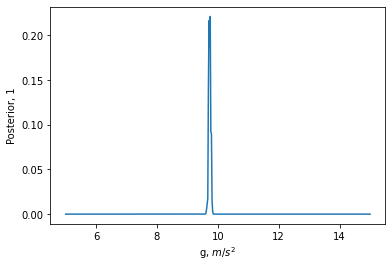

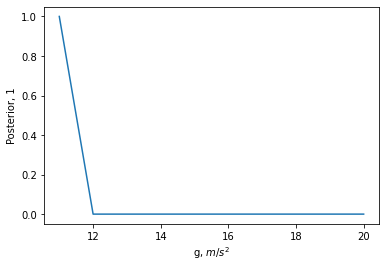

In [26]:
# Note how inference without assumptions is impossible - and by constraining g to a wrong interval, we happyly infer something
for gs in (jnp.linspace(5, 15, num=500, dtype=np.float32),
           jnp.linspace(11, 20, num=10, dtype=np.float32)):
    rng, subkey = jax.random.split(rng)
    posterior = compute_posterior(subkey, gs)
    fig, ax = plt.subplots()
    ax.plot(gs, posterior)
    ax.set_xlabel("g, $m/s^2$")
    ax.set_ylabel("Posterior, 1");

# Task 1: Find the parameters from an unknown trajectory
You are given an "observed" trajectory. It has been simulated with the following function `sample_trajectory_by_params`. Known parameters:
* `m1 = 1` kg
* `l1 = 1` m

Your objective is to find the value of the unknown parameters minimising MAPE between the predicted and true values. The parameters lie in the following intervals:
* `m2` $\in [10^{-2}, 10^{2}]$
* `l2` $\in [10^{-2}, 10^{2}]$
* `g` $\in [10^{-2}, 10^{2}]$
* `noise_std` $\in (0, 1]$

In [27]:
t_task = np.linspace(0, 10, num=100, dtype=np.float32)
def sample_trajectory_by_params(key, params={"m1":1, "m2":1, "l1":1, "l2":1, "g":9.8}, noise_std=0.5):
    # odeint is bugged with vmap, probably becouse of the control flow to maintain tolerance
    true_trajectory = pendulum.solve_analytical(x0, t_task, **params)
    return true_trajectory + jax.random.normal(key, true_trajectory.shape, true_trajectory.dtype)*noise_std

In [28]:
example_trajectory = sample_trajectory_by_params(rng)

So many options... Grid search, random search, annealing, gradient optimisation...

In [29]:
target_paramse = {"m1":1, "m2":5.5, "l1":1, "l2":0.8, "g":13.3}
target_noise = 0.55

In [30]:
target_trajectory = sample_trajectory_by_params(rng, target_paramse, target_noise)

In [31]:
np.savez_compressed("task_1_target.npz", target_trajectory=np.array(target_trajectory))

In [32]:
with np.load("task_1_target.npz", allow_pickle=False ) as input_file:
    target_trajectory = input_file["target_trajectory"]